In [62]:
import pandas as pd
import torch 
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import lru_cache


In [63]:
np.version.version

'1.26.4'

In [64]:
@lru_cache(maxsize=1024)
def configs(conc):
    df = {}
    for x in range(1000):
        path = os.path.expanduser(f'~/Downloads/transmissions/transmissions/size_25_conc_{conc}_config_{x}.csv')
        new_data = np.loadtxt(path, delimiter=',')
        df[x] = new_data
    df = pd.DataFrame(df)
    df.index = np.arange(0, 4, 0.01)
    return df.clip(upper=25)



In [65]:
for frames in np.arange(5,50,5):
    df = configs(frames)

In [66]:
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform


In [67]:
np.random.seed(42)
random_configs =sorted(np.random.choice(np.arange(0,999,1), 800,replace=False))

In [68]:
for conc in np.arange(5,50,5):
    train = configs(conc).iloc[:,random_configs]
    test = configs(conc).drop(columns=random_configs)
    train.to_csv(f'~/Downloads/transmissions/train_conc_{conc}.csv')
    test.to_csv(f'~/Downloads/transmissions/test_conc_{conc}.csv')

In [69]:
DEVICE_COMBS = {}

@lru_cache(maxsize=1024)
def chosen_for_config(n, width, config):
    width = int(width); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed

In [70]:
@lru_cache(maxsize=1024)
def distance_matrix(conc,config):
    imps  = possible_combs(conc, 25)
    item = imps(config)
    #print(np.diag(item[:,1]))
    return squareform(pdist(item, metric='euclidean')) + np.diag(item[:,1])


In [71]:
x= []
y = []

for config in range(1000):
    dist_mat = distance_matrix(5, config)
    x.append(dist_mat)
    arr = configs(5).index,configs(5)[config]
    arr = np.array(arr).T
    y.append(arr)

In [72]:
x = np.array(x)
y = np.array(y)
print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")

Shape of x: (1000, 5, 5)
Shape of y: (1000, 400, 2)


In [79]:
import torch
import torch.nn as nn

In [82]:
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [100]:
class CNNRegressor(nn.Module):
    def __init__(self, out_features=800):
        super(CNNRegressor, self).__init__()
        # Part 1: CNN layers to read the 5x5 matrix
        self.cnn_part = nn.Sequential(
            # Input is (Batch, 1,  5, 5)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # -> (Batch, 16, 5, 5)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1), # -> (Batch, 16, 4, 4)
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # -> (Batch, 32, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1) # -> (Batch, 32, 3, 3)
        )
        
        # Part 2: Flatten and Fully Connected layers for regression
        self.mlp_part = nn.Sequential(
            nn.Flatten(),
            # After flattening, the size is 144, which must match the in_features below
            nn.Linear(in_features=32*3*3, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=out_features) # Final output layer
        )

    def forward(self, x):
        x = self.cnn_part(x)
        x = self.mlp_part(x)
        return x

In [101]:
X_tensor = torch.tensor(X_flat, dtype=torch.float32)
Y_tensor = torch.tensor(y, dtype=torch.float32).view(-1,1)

In [102]:
class MatrixDataset(Dataset):
    """Dataset for (5x5 matrix) -> (400x2 matrix) regression."""
    
    def __init__(self, x_matrices, y_matrices):
        # Prepare X: add channel dimension
        self.X = torch.tensor(np.array(x_matrices), dtype=torch.float32).unsqueeze(1)
        
        # Prepare Y: flatten the 400x2 matrix into a 1D vector of size 800
        num_samples = y_matrices.shape[0]
        self.y = torch.tensor(y_matrices, dtype=torch.float32).reshape(num_samples, -1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [103]:
full_dataset = MatrixDataset(x, y)
loader = DataLoader(full_dataset, batch_size=32, shuffle=True)

In [104]:
from torch.utils.data import Dataset, DataLoader, random_split

In [106]:

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


# --- 4. The Training Loop ---

# Set device (use GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 100

# Initialize the model, loss function, and optimizer
model = CNNRegressor(out_features=800).to(device)
loss_fn = nn.MSELoss() # Mean Squared Error is good for regression
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Start Training ---
for epoch in range(EPOCHS):
    model.train() # Set the model to training mode
    
    # Loop over the training data
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move data and targets to the selected device
        data = data.to(device)
        targets = targets.to(device)
        
        # 1. Forward pass: get predictions
        predictions = model(data)
        
        # 2. Calculate loss
        loss = loss_fn(predictions, targets)
        
        # 3. Backward pass: compute gradients
        optimizer.zero_grad() # Reset gradients from previous step
        loss.backward()
        
        # 4. Update weights
        optimizer.step()

    # --- Validation Loop ---
    model.eval() # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad(): # Disable gradient calculation for validation
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            
            predictions = model(data)
            val_loss += loss_fn(predictions, targets).item()
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Training Loss: {loss.item():.4f} | Validation Loss: {avg_val_loss:.4f}")

print("\nTraining finished!")


Using device: cpu
Epoch 1/100 | Training Loss: 15.1618 | Validation Loss: 14.8153
Epoch 2/100 | Training Loss: 12.4773 | Validation Loss: 13.1717
Epoch 3/100 | Training Loss: 12.9364 | Validation Loss: 13.2821
Epoch 4/100 | Training Loss: 10.9415 | Validation Loss: 12.0025
Epoch 5/100 | Training Loss: 11.5499 | Validation Loss: 11.5251
Epoch 6/100 | Training Loss: 10.6852 | Validation Loss: 11.3298
Epoch 7/100 | Training Loss: 11.2848 | Validation Loss: 10.8508
Epoch 8/100 | Training Loss: 10.8573 | Validation Loss: 11.0920
Epoch 9/100 | Training Loss: 9.5577 | Validation Loss: 11.0717
Epoch 10/100 | Training Loss: 10.4395 | Validation Loss: 10.9652
Epoch 11/100 | Training Loss: 10.2226 | Validation Loss: 10.4704
Epoch 12/100 | Training Loss: 10.5482 | Validation Loss: 10.8096
Epoch 13/100 | Training Loss: 9.9708 | Validation Loss: 10.3719
Epoch 14/100 | Training Loss: 10.2075 | Validation Loss: 10.3061
Epoch 15/100 | Training Loss: 9.2317 | Validation Loss: 10.9763
Epoch 16/100 | Trai


--- Checking a sample prediction ---
Input 5x5 Matrix:
[[19.       67.       57.31492  84.14868  13.038404]
 [67.       19.       11.661903 17.720045 56.435802]
 [57.31492  11.661903 13.       29.15476  46.010868]
 [84.14868  17.720045 29.15476  24.       73.97973 ]
 [13.038404 56.435802 46.010868 73.97973  12.      ]]


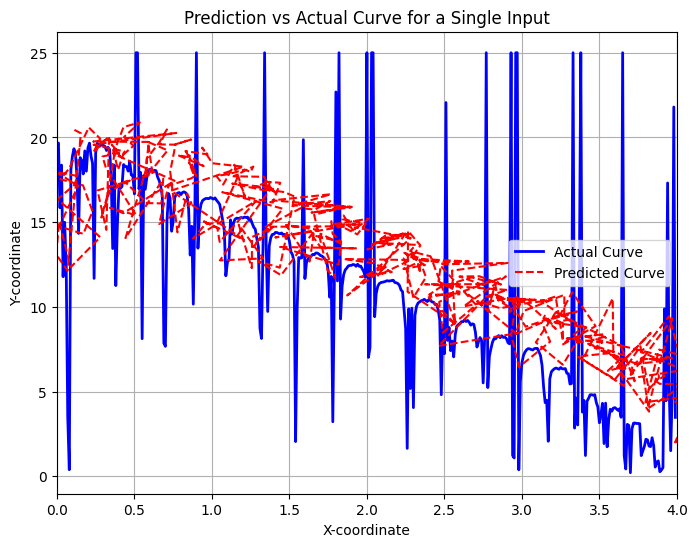

In [110]:


# --- 5. Making and Plotting Predictions ---
print("\n--- Checking a sample prediction ---")
model.eval() # Set the model to evaluation mode

# Get a single batch from the validation loader
with torch.no_grad():
    inputs, targets = next(iter(val_loader))
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Get the model's predictions for this batch
    predictions = model(inputs)
    
    # --- Let's look at the very first sample in the batch ---
    
    # Get the original 5x5 input matrix
    input_matrix = inputs[0].cpu().numpy().squeeze()
    
    # The prediction is a flat vector of 800 numbers. Reshape it back to 400x2.
    pred_matrix = predictions[0].reshape(400, 2).cpu().numpy()
    
    # The target is also a flat vector. Reshape it back as well.
    target_matrix = targets[0].reshape(400, 2).cpu().numpy()

    # Print the input matrix
    print("Input 5x5 Matrix:")
    print(input_matrix)
    
    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.plot(target_matrix[:, 0], target_matrix[:, 1], label='Actual Curve', color='blue', linewidth=2)
    plt.plot(pred_matrix[:, 0], pred_matrix[:, 1], label='Predicted Curve', color='red', linestyle='--')
    plt.title('Prediction vs Actual Curve for a Single Input')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.xlim(0, 4)
    plt.legend()
    plt.grid(True)
#    plt.axis('equal')
    plt.show()

